<a href="https://colab.research.google.com/github/michellepi/MIC-Project-A/blob/main/Mini_Project_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project Part A
### __Deadline: 23 February 2022 4pm__

Solve all the questions in this notebook. When asked, write comments to markdown cells. Submit the solved notebook on KEATS. Do not submit any other files. All answers and images must be visible in your submitted notebook, we will not rerun your code. Your code must be clear and concise, you may loose marks for lenghty redundand code.

Marks for this coursework will be converted to __30% of your final grade__.

If instructions are not clear, please e-mail maria.deprez@kcl.ac.uk. Do not e-mail questions about *how* you should solve this coursework, as you are assessed for your independent work.

In [ ]:
# Install SimpleITK 
!pip install SimpleITK

In [ ]:
import os

In [ ]:
# # Mount your drive to colab 
from google.colab import drive
drive.mount('/content/drive')

# Change to the path to the folder with the input files (YOU MIGHT NEED TO CHANGE IT)
# make sure you upload all data and .py files to this directory on your drive
root_dir = '/content/drive/My Drive/MIC-assignment'
os.chdir(root_dir)
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['display.py',
 'Mini Project Part A.pdf',
 '.ipynb_checkpoints',
 'image',
 'atlas',
 'ground_truth',
 'template',
 '__pycache__',
 'segmentation.py',
 'registration.py',
 'Mini_Project_Part_A.ipynb']

In [ ]:
# Import libraries
import os
import numpy as np
import sys

import numpy as np
import matplotlib.pyplot as plt 
import SimpleITK as sitk

## Aim
The aim of this coursework is to apply registration and segmentation techniques to delieate white matter in a brain MRI image. To help you, you are given several files with different functions that you are expected to use to solve the questions in this notebook.

Run the cell below to load the image that you will segment.

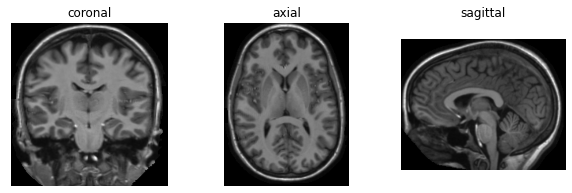

In [ ]:
# load function from file display.py
from display import Display3D

# load image as float32
sitk_image = sitk.ReadImage('image/image.nii.gz', sitk.sitkFloat32)
# display the loaded image
Display3D(sitk_image)

## Question 1: Masking
__[15 marks]__

Before we can use intensity-based segmentation such as GMM, we need to remove the non-brain tissues. To do that:
* register the atlas to the image using affine registration
* propagate the mask that comes with the atlas to the image
* multiply the image by the mask to remove the non-brain tissue

The atlas T1 template and the mask are loaded below:

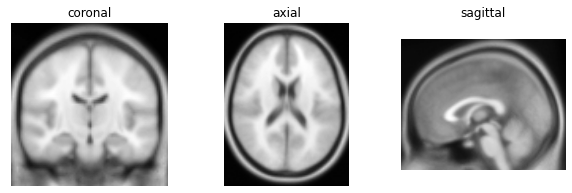

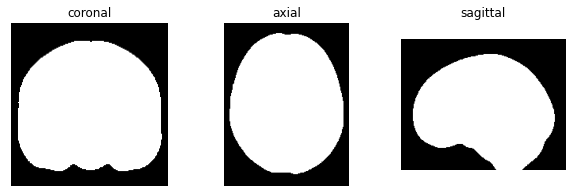

In [ ]:
sitk_atlas = sitk.ReadImage('atlas/t1.nii.gz', sitk.sitkFloat32)
sitk_mask = sitk.ReadImage('atlas/mask.nii.gz', sitk.sitkFloat32)
Display3D(sitk_atlas)
Display3D(sitk_mask)

__Task 1.1 [5 marks]:__ Register the atlas to the image

The atlas is currently not aligned with the image. 
* register atlas to the image using affine transformation
* resample altas on the grid of the image using this transformation
* show the alignment using overlay

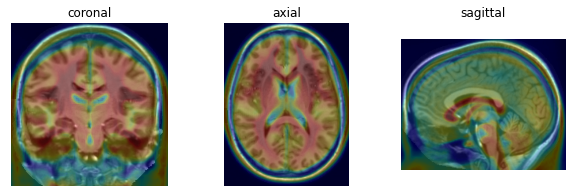

In [ ]:
# import function from display.py
from display import PlotOverlay3D
# images are misaligned
PlotOverlay3D(sitk_image,sitk_atlas,0.3,'jet')

In [ ]:
# import functions from registration.py
from registration import AffineRegistration
from registration import resample_image

In [ ]:
# run affine registration of atlas to image 
atlas_affine = AffineRegistration(sitk_image, sitk_atlas)



Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
-------
itk::simple::Transform
 AffineTransform (0x55f3d08a0fc0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 2105
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.10893 -0.0294653 -0.00437489 
     0.0221134 0.999565 -0.0853273 
     0.0161121 0.0804427 1.15179 
   Offset: [-7.11811, -11.8462, -11.6258]
   Center: [109, 140.5, -119.5]
   Translation: [1.13789, 0.699761, -16.7062]
   Inverse: 
     0.901173 0.0261336 0.00535901 
     -0.0208883 0.9939 0.0735511 
     -0.0111474 -0.0697811 0.863002 
   Singular: 0

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (20) exceeded.
 Iteration: 20
 Metric valu

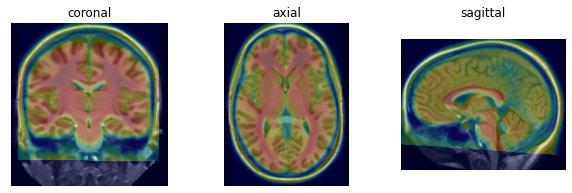

In [ ]:
# resample atlas to image space
atlas_resample = resample_image(sitk_image, sitk_atlas, atlas_affine)

# display overlay to check that images are aligned
PlotOverlay3D(sitk_image,atlas_resample,0.3,'jet')

__Task 1.2 [3 marks]:__ Propagate mask to the image
* resample mask on the grid of the image using the affine transformation
* display resampled mask overlayed on the image

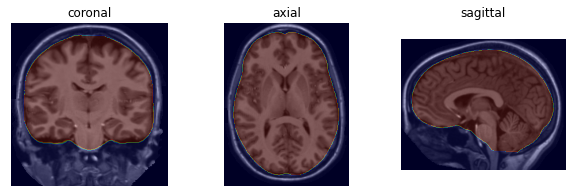

In [ ]:
# resample
mask_resample = resample_image(sitk_image, sitk_mask, atlas_affine)

# display
PlotOverlay3D(sitk_image,mask_resample,0.3,'jet')


__Task 1.3 [7 marks]:__ Remove non-brain tissue from the image
* extract the the aligned mask and the image as numpy arrays from the sitk images
* binarize the mask by thresholding at 0.5
* multiply mask and image
* convert back to sitk image

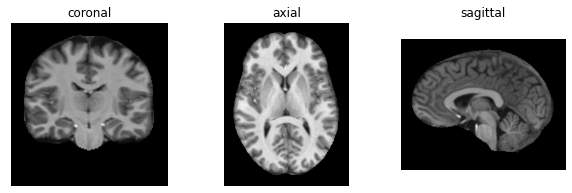

In [ ]:
# extract numpy arrays
image = sitk.GetArrayFromImage(sitk_image)
mask = sitk.GetArrayFromImage(mask_resample)

# binarise mask at 0.5
mask[mask>=0.5]=1
mask[mask<0.5]=0

# multiply image with the mask
image_masked = image * mask

# convert masked image to sitk
sitk_image_masked = sitk.GetImageFromArray(image_masked)
sitk_image_masked.CopyInformation(sitk_image)

# display masked image
Display3D(sitk_image_masked)

## Question 2: Segmentation using Gaussian Mixture Model
__[20 marks]__

In this question you will apply a 3-class Gaussian Mixture Model from __scikit-learn__ to segment the masked image. You will also evaluate the performance of the GMM segmentation by comparing to ground truth white matter segmentation.

__Task 2.1 [8 marks]:__ Perform 3-class segmentation of the maked image using `sklearn GaussianMixture`. To do that
* convert sitk image to numpy (or use the one already created)
* extract non-zero voxels
* perform GMM clustering and predict labels
* reshape labels back to 3D array and convert to sitk image
* display the resulting segmentation

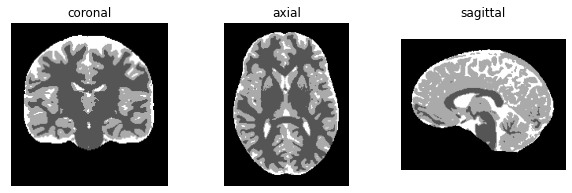

In [ ]:
from sklearn.mixture import GaussianMixture

# extact non-zero values and reshape into feature vector for sklearn
ind = np.where(mask>0)
features = image[ind].reshape(-1,1)
    
# create GMM model, fit and predict labels
gmm = GaussianMixture(n_components=3)
gmm.fit(features)
labels_pred = gmm.predict(features)
    
# reshape labels to a 3D image 
labels3D = np.zeros_like(image)
labels3D[ind] = labels_pred + 1

# convert to sitk image
sitk_labels3D = sitk.GetImageFromArray(labels3D)
sitk_labels3D.CopyInformation(sitk_image)

# display segmentation
Display3D(sitk_labels3D)

__Task 2.2 [8 marks]:__ Evaluate segmentation
* Extract binary white matter label from the segmentation and display it
* calculate Dice Coefficient between GMM and manual segmentation of WM
* calculate Hausdorff distance and average Hausdorf distance

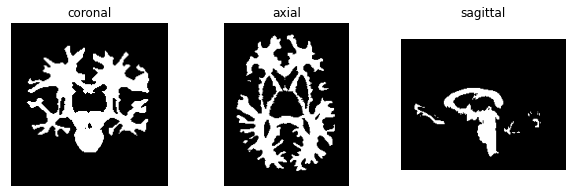

In [ ]:
# load ground truth segmentation
sitk_gt = sitk.ReadImage('ground_truth/wm.nii.gz', sitk.sitkFloat32)
Display3D(sitk_gt)

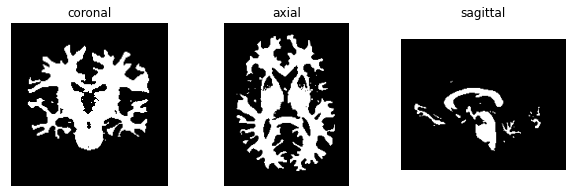

In [ ]:
# extract WM label from numpy label array

def extract_wm(labels,c):
    wm = np.zeros_like(labels)
    wm[labels==c]=1
    return wm

wm_label = extract_wm(labels3D, 1)

# convert to sitk
sitk_wm_label = sitk.GetImageFromArray(wm_label)
sitk_wm_label.CopyInformation(sitk_image)

# display wm label
Display3D(sitk_wm_label)

In [ ]:
# Import Dice function from segmentation.py
from segmentation import Dice

# Calculate Dice Coefficient (use numpy arrays)
wm_gt = sitk.GetArrayFromImage(sitk_gt)
gmm_dice = Dice(wm_label, wm_gt)


Dice = 0.93


In [ ]:
# import Housdorf function from segmentation.py
from segmentation import Hausdorff

# calculate Hausforff and average Housdorff distances. Use sitk images to do that.
gmm_hausdorff = Hausdorff(sitk_wm_label, sitk_gt)


Housford distance: 11.75
Average Housedorf distance: 0.12


__Task 2.3 [4 marks]:__ Explain what the three quantitative measures tell you about the performance of the segmentation.

__Your answer:__

The dice coefficient show that there is a high overlap between the segmentation and the groun truth. Despite the thinner and complex sections of the white matter the dice coefficient is still high. The Housdorff distance of the segmentation is large, this shows that the most incorrect segmentation to be far from the ground truth. Despite this, the average distance is low, which suggest most of the segmentation is still close to the ground truth.

## Question 3: Your own Gaussian Mixture Model
__[10 marks]__

Now we will implement a segmentation using Gaussian Mixture model in numpy. You do not need to start from scratch, the function that you need are given to you in `segmentation.py`. You need to perform following steps:
* Initialise GMM parameters, which include cluster means, variances and mixing proportions
* Implement 10 iterations of EM algorithm, where in E-step you update probability maps and in M-step you update the parameters
* Create a segmentation from the probability maps and display it

In [ ]:
# import functions from segmentation.py
from segmentation import init_parameters
from segmentation import update_probability
from segmentation import update_parameters
from segmentation import create_segmentation

In [ ]:
# initialise GMM parameters
means, variances, mix = init_parameters(features)


means [27.43 54.86 82.29]
variances [270.84 270.84 270.84]
mix [0.33 0.33 0.33]


In [ ]:
# implement 10 iteration of to update probability maps and parameters
for i in range(0, 10): 
  p = update_probability(features, means, variances, mix)
  means, variances, mix = update_parameters(features, p)

means [33.04 54.23 75.36]
variances [129.45 130.13  51.97]
mix [0.27 0.44 0.3 ]
means [32.3  52.96 76.23]
variances [115.13  78.65  24.45]
mix [0.27 0.41 0.32]
means [32.01 53.04 76.51]
variances [109.52  66.84  20.7 ]
mix [0.27 0.41 0.32]
means [32.06 53.3  76.59]
variances [107.61  65.54  19.89]
mix [0.28 0.41 0.32]
means [32.22 53.51 76.66]
variances [107.72  65.53  19.4 ]
mix [0.28 0.4  0.32]
means [32.4  53.7  76.71]
variances [108.35  65.65  19.02]
mix [0.29 0.4  0.31]
means [32.59 53.88 76.75]
variances [109.07  65.7   18.69]
mix [0.29 0.4  0.31]
means [32.78 54.05 76.79]
variances [109.82  65.66  18.41]
mix [0.29 0.39 0.31]
means [32.97 54.23 76.83]
variances [110.56  65.53  18.16]
mix [0.3  0.39 0.31]
means [33.17 54.4  76.86]
variances [111.3   65.33  17.95]
mix [0.3  0.39 0.31]


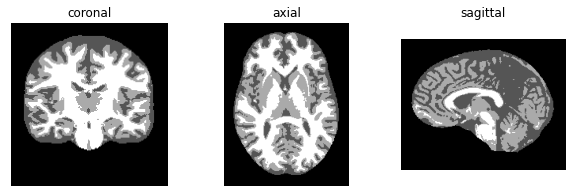

In [ ]:
# create and display segmentation
gmm_seg = create_segmentation(sitk_image, ind, p)

Display3D(gmm_seg)

## Question 4: EM segmentation with probabilistic atlas
__[30 marks]__

In this question you will amend the code from question 3 to implement EM segmentation where you will relace mixing proportions with priors from a probabilistic atlas. To do that you will
* resample the the atlas probability maps for WM, GM and CSF to the space of an image using the affine transformation that you calculated in Question 1
* update functions for E-step and M-step from Question 3 to repace mixing proportions by the probability maps
* run the algotihm for 10 iterations and create the segmentation
* evaluate the accuracy of the WM segmentation using Dice, Hausforff and average Hausdorff distance as in Question 2.


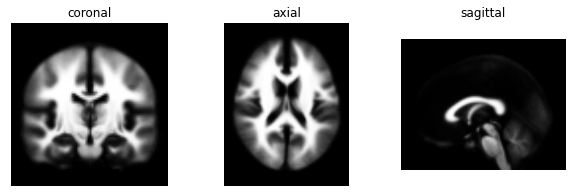

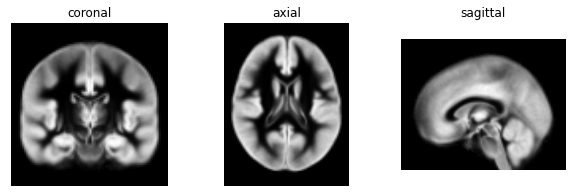

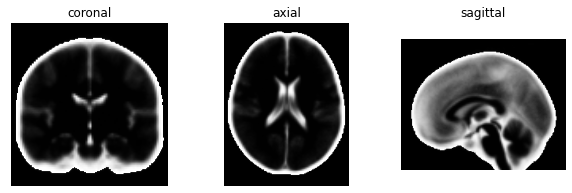

In [ ]:
# load the probability maps
sitk_wm = sitk.ReadImage('atlas/wm.nii.gz', sitk.sitkFloat32)
sitk_gm = sitk.ReadImage('atlas/gm.nii.gz', sitk.sitkFloat32)
sitk_csf = sitk.ReadImage('atlas/csf.nii.gz', sitk.sitkFloat32)

# display
Display3D(sitk_wm)
Display3D(sitk_gm)
Display3D(sitk_csf)

__Task 4.1 [6 marks]:__ Align the probability maps loaded above to the space of the image. To do that
* Resample them to the space of the image using affine transformation that you calculated in Question 1
* Display each of the three probability maps overlayed on the image to check the alignment
* Convert each probability map into numpy array to prepare it for EM segmentation.

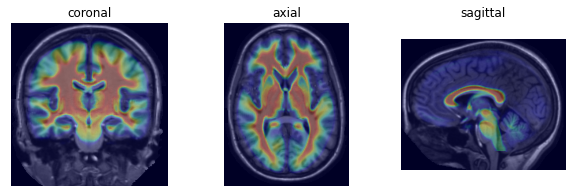

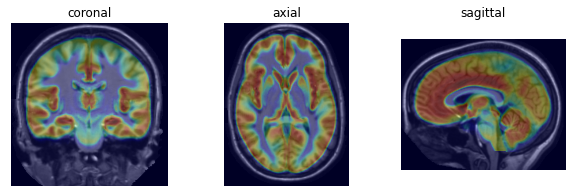

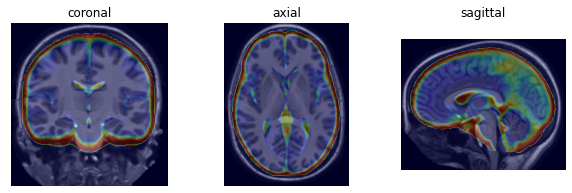

In [ ]:
# Resample probability maps for WM, GM ans CSF
resample_wm = resample_image(sitk_image, sitk_wm, atlas_affine)
resample_gm = resample_image(sitk_image, sitk_gm, atlas_affine)
resample_csf = resample_image(sitk_image, sitk_csf, atlas_affine)

# Display probability maps as overlay on the image to check that they are aligned
PlotOverlay3D(sitk_image,resample_wm,0.3,'jet')
PlotOverlay3D(sitk_image,resample_gm,0.3,'jet')
PlotOverlay3D(sitk_image,resample_csf,0.3,'jet')

# Convert to numpy
wm_reg = sitk.GetArrayFromImage(resample_wm)
gm_reg = sitk.GetArrayFromImage(resample_gm)
csf_reg = sitk.GetArrayFromImage(resample_csf)


__Task 4.2 [6 marks]:__ Initialise the EM segmentation
Because we now have inital probability maps in form of the registered atlas, we can use them to initialise means and variances in more robust way. To do that
* create an initial probability vector `a` using probabilistic atlas
* initialise means and variances by updated M-step function `update_parameters_EM`

The cell below contains code to extract probability map voxels corresponding to non-zero intensities in the masked image and join the probability maps into a single probability vector. Run the cell.

In [ ]:
# extract prior probabilities for non-zero voxels
a_wm = wm_reg[ind]
a_gm = gm_reg[ind]
a_csf = csf_reg[ind]

# stack them into a single vector
a=np.stack([a_csf,a_gm,a_wm],axis=1)
a.shape

(1626229, 3)

Explain what the first and second dimension of the vector `a` represents.

__Your answer:__



The first dimension of vector a represent the probabilities that a voxel belongs to each class.

The second dimension represent the probabilities of each voxel belonging to a class (gaussian distribution)

Now initialise the EM segmentation parameters (means and variances) by running the M-step. To do that perform following:
* Amend the function `update_parameters_EM` so that it does not calculate or return the mixing proportions, as these will be replaced by the probabilistic atlas
* Run the amended function  using the probability map vector `a` constructed in the cell above to calculate and print initial means and variances.

In [ ]:
# amend function
def update_parameters_EM(features,p):
    n=p.shape[0]
    means=np.zeros(3)
    variances=np.zeros(3)
    mix=np.zeros(3)
    for k in range(0,3):
        means[k]=np.sum(p[:,k]*features.flatten())/np.sum(p[:,k])
        variances[k]=np.sum(p[:,k]*(features.flatten()-means[k])**2)/np.sum(p[:,k])
        #mix[k] = np.sum(p[:,k])/n
    print('means', np.around(means,2))
    print('variances', np.around(variances,2))
    #print('mix',np.around(mix,2))
    return means,variances#,mix

# run function
means, variances = update_parameters_EM(features, a)

means [40.71 53.84 64.93]
variances [344.36 272.05 252.44]


__Task 4.3 [5 marks]:__ Update the E-step function `update_probability_EM`. To do that
* remove the `mix` parameters, as they will not be used any more
* when calculating likelihoods `p`, replace `mix[k]` with with the prior probability maps `a`
* run the function to calculate posterior probability maps `p`
* the code to display the maps `p` is there for you

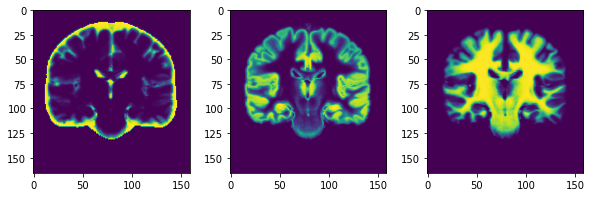

In [ ]:
from segmentation import gauss

# amend function
def update_probability_EM(features,means,variances):
    p=np.zeros([features.shape[0],3])
    for k in range(3):
        p[:,k] = gauss(features.flatten(),means[k],variances[k])*a[:,k]
    denom = np.matlib.repmat(np.sum(p,1), 3, 1).T
    p=p/denom
    return p

# run function
p = update_probability_EM(features,means, variances)

# print probability maps
from segmentation import plot_probability
plot_probability(sitk_image, ind, p)

__Task 4.4 [7 marks]:__ Calculate EM segmentation. To do that:
* Run the new E-step and M_step for 10 iterations
* Create the segmentation
* Display the resulting segmentation

In [ ]:
# Run the new E-step and M_step for 10 iterations
for i in range(0,10):
  p = update_probability_EM(features, means, variances)
  means, variances = update_parameters_EM(features, p)



means [34.73 52.13 71.21]
variances [219.66 173.21 119.08]
means [32.33 50.24 74.53]
variances [176.45  97.05  44.67]
means [31.11 50.13 75.54]
variances [164.44  69.75  25.14]
means [30.81 50.75 75.94]
variances [157.01  67.32  20.37]
means [30.82 51.27 76.23]
variances [152.63  69.37  17.87]
means [30.89 51.65 76.47]
variances [150.97  72.16  16.06]
means [30.96 51.95 76.66]
variances [150.57  74.9   14.67]
means [31.03 52.19 76.81]
variances [150.63  77.37  13.61]
means [31.09 52.38 76.93]
variances [150.81  79.49  12.8 ]
means [31.14 52.53 77.03]
variances [150.98  81.28  12.18]


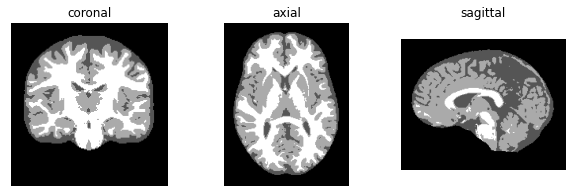

In [ ]:
# Create and display segmentation (see Q3)
em_seg = create_segmentation(sitk_image, ind, p)

Display3D(em_seg)


__Task 4.5 [6 marks]:__ Calculate Dice coefficient, Hausdorf distance and average Housdorff distance  for the EM segmentation compared to the ground truth WM segmentation. (See Q2)

Dice = 0.85
Housford distance: 15.13
Average Housedorf distance: 0.19


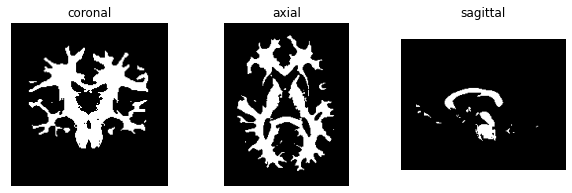

In [ ]:
# extract EM segmentation as numpy array
em_seg_arr = sitk.GetArrayFromImage(em_seg)

# extract WM label
em_wm_label = extract_wm(em_seg_arr, 3)

# calculate Dice
em_dice = Dice(em_wm_label, wm_gt)

# convert to sitk
sitk_em_wm_label = sitk.GetImageFromArray(em_wm_label)
sitk_em_wm_label.CopyInformation(sitk_image)

# display wm label
Display3D(sitk_em_wm_label)

# Calculate Housdorff distances
em_hausdorff = Hausdorff(sitk_em_wm_label, sitk_gt)

## Question 5: Label propagation
__[25 marks]__

We load the template and template WM labels to ants format and plot the labels overlayed on the template using ants library plotting function:

In [ ]:
# install ants
# works on Colab but might not work on your local system
!pip install antspyx

     |████████████████████████████████| 300.3 MB 30 kB/s 
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=2a455c8ad3baf0d1e6c1e907351b97011d78e017dd2b4fc8950ecc402f5c5a95
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
# import ants
import ants

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


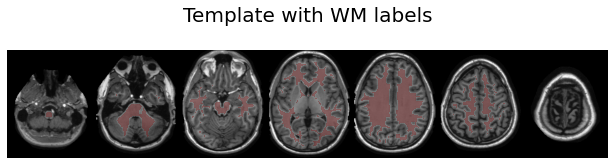

In [ ]:
# load the template and the WM labels in ants format
ants_template = ants.image_read('template/template.nii.gz')
ants_template_wm = ants.image_read('template/wm.nii.gz')
ants.plot(ants_template, ants_template_wm, 
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, 
          title="Template with WM labels")

We also load the image in ants format and overlay the template on it. We see that they are note aligned.

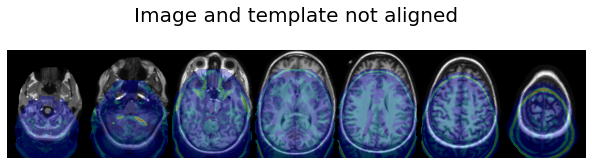

In [ ]:
# load the image in ants format
ants_image = ants.image_read('image/image.nii.gz')

# image and template are not aligned
ants.plot(ants_image, ants_template, 
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, 
          title="Image and template not aligned")

__Task 5.1 [5 marks]:__ Perform affine registration of template to image. Transform the template to the image and show aligment using overay from ants package. 

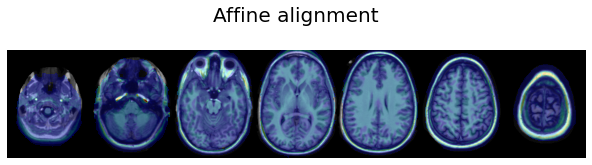

In [ ]:
# perform affine registration (takes ~40s)
t_affine = ants.registration( fixed=ants_image, moving=ants_template,
                               type_of_transform='Affine' )
# transform template 
ants_template_affine = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',
                                           transformlist=t_affine['fwdtransforms'] )
# check alignment
ants.plot(ants_image, ants_template_affine,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, 
          title="Affine alignment")

__Task 5.2 [5 marks]:__ Perform non-linear alignment, initialised by affine transformation. Initialy use registration parameters `reg_iterations = [40,20,0]` to obtain a quick but less accurate registration. Once your code is working, change it to `[40,40,40]` to obtain better result, but it will take ~25 minutes on Colab to complete.

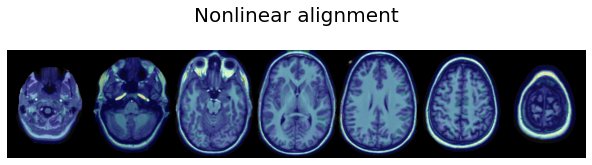

In [ ]:
# perform non-linear registration initialised with affine
t_nonlinear = ants.registration( fixed=ants_image, moving=ants_template,
                            initial_transform = t_affine['fwdtransforms'][0],
                            #reg_iterations = [40,20,0], # lower quality (takes ~2 mins)
                            reg_iterations = [40,40,40], # higher quality (takes ~25 mins)
                            type_of_transform='SyNOnly')
# transform template 
ants_template_nonlinear = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',
                                           transformlist=t_nonlinear['fwdtransforms'] )

# check alignment
ants.plot(ants_image, ants_template_nonlinear, 
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3, 
          title="Nonlinear alignment")

__Task 5.3: [3 marks]__ Propagate the template WM labels from template to image space. Plot propagated labels overlayed on the image using the ants package.

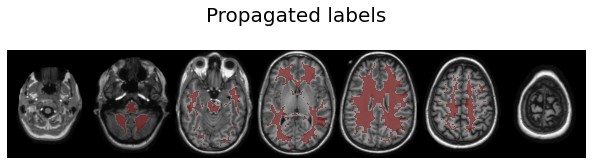

In [ ]:
# propagate labels
propagated_labels = ants.apply_transforms( fixed=ants_image, moving=ants_template_wm, 
                                             interpolator='nearestNeighbor', transformlist=t_nonlinear['fwdtransforms'] )
# plot propagated labels overlayed on the image
ants.plot(ants_image, propagated_labels, 
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.5, 
          title="Propagated labels")

__Task 5.4 [5 marks]:__ The code in the cell below reads the ground truth labels for the image. Calculate the Dice coefficient and Hausforff distances, after converting the ants propagated and ground truth WM labels into appropriate formats.

In [ ]:
# Dice 

# read ground truth segmentation in ants format
ants_gt = ants.image_read('ground_truth/wm.nii.gz')

# calculate dice coefficient (hint: convert ants images to numpy)
p_wm_label = propagated_labels.numpy()
p_wm_gt = ants_gt.numpy()

p_dice = Dice(p_wm_label, p_wm_gt)

Dice = 0.8


In [ ]:
# Hausdorff

# convert ants images first to numpy and then to sitk
sitk_wm_label = sitk.GetImageFromArray(p_wm_label)
sitk_wm_gt = sitk.GetImageFromArray(p_wm_gt)

# calculate Hausforf distances
p_hausdorff = Hausdorff(sitk_wm_label, sitk_wm_gt)

Housford distance: 8.37
Average Housedorf distance: 0.32


__Task 5.5 [7 marks]:__ Analyse the performance of the three WM segmentation methods (GMM, EM with probabilistic atlas, label propagation) in terms of their quantitative results. Explain the advantages and disadvantages of each of the methods as shown by each of the three quantitative measures.

__Your answer:__


The label propagation method has the advantage of already having accurate clinically relevant information, which stops it from straying far from a typical white matter region. This can be seen as it outperforms other methods in terms of Hausdorff distance. The disadvantage is that it is limited by the accuracy of the registration as can be seen by it having the lowest dice coefficient and average distance, so although it generally stays closer to the ground truth it is overall not as accurate. The EM segmentation uses the same prior knowledge but improves it and can be shown that the dice coefficient and average distance is higher compared to just the label propagation. The GMM performed best overall as shown by the measures, this may be because it was fit using the optimat number of iterations while the EM was done for 10 iterations. The Hausdorff distance is higher than the label propagations as it did not have the prior infromation.